In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
air_data = pd.read_csv('USA Airport Dataset.zip')
print(air_data.shape)
air_data.sample(5)

(3606803, 15)


,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
3173568,CVG,PFN,"Cincinnati, OH","Panama City, FL",94,100,2,612,2008-06-01,2158643,163802,39.048801,-84.667801,30.212099,-85.682800
1919924,FAI,ANC,"Fairbanks, AK","Anchorage, AK",1956,3096,43,261,2008-07-01,98351,365790,64.815102,-147.856003,61.174400,-149.996002
3122694,RFD,MSP,"Rockford, IL","Minneapolis, MN",0,0,1,278,2006-09-01,344269,3167666,42.195400,-89.097198,44.882000,-93.221802
2017290,MCO,CLT,"Orlando, FL","Charlotte, NC",0,50,1,468,2001-03-01,1708955,1375381,28.429399,-81.308998,35.214001,-80.943100
777803,MSY,ORD,"New Orleans, LA","Chicago, IL",6064,8198,59,837,1996-04-01,1287349,17287860,29.993401,-90.258003,41.978600,-87.904800


In [4]:
# dropping records with nulls present
df = air_data.dropna(axis=0, how='any')
print(df.shape)

(3594452, 15)


# Time Series Analysis (Passengers v/s Years)

In [5]:
# Changing the date data type for time series

df['new_date'] = pd.to_datetime(df.Fly_date)
df['fly_yr'] = df['new_date'].dt.year
df['yr_mn'] = df['new_date'].dt.strftime('%Y-%m')


In [6]:
group1 = df.groupby(['yr_mn']).agg({'Passengers':'sum'}).reset_index()
group1.index = group1['yr_mn']

del group1['yr_mn']
group1.head()

,Passengers
yr_mn,
1990-01,27601308
1990-02,27006768
1990-03,32943771
1990-04,31172398
1990-05,31199271


In [7]:
# On the basis of the plot below we can conduct a time series forecast
# of the number of passengers that would travel in the subsequnet months 
# check for stationary

rolling_mean = group1.rolling(7).mean()
rolling_std = group1.rolling(7).std()

plt.figure(figsize=(30,15), dpi=100)
plt.plot(group1, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")

plt.title("Passenger Time Series, Rolling Mean, Standard Deviation", fontsize=30)
plt.xticks(rotation=90, fontsize=10)
plt.legend(loc="best", fontsize=20)
plt.show()

## Checking Seasonality of Data

In [8]:
# Dickey Fuller Test to Check the Stationarity in Data

# H0 = There is no stationarity present in the data
# Ha = There is stationarity present in the data


from statsmodels.tsa.stattools import adfuller 

adft = adfuller(group1['Passengers'],autolag="AIC")

output_df = pd.DataFrame({"Values": [adft[0], adft[1], adft[2], adft[3], adft[4]['1%'],
                                     adft[4]['5%'], adft[4]['10%']],
                          "Metric":["Test Statistics", "p-value" ,"No. of lags used", "Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
(output_df)

,Values,Metric
0,-2.024725,Test Statistics
1,0.275838,p-value
2,14.000000,No. of lags used
3,225.000000,Number of observations used
4,-3.459752,critical value (1%)
5,-2.874473,critical value (5%)
6,-2.573663,critical value (10%)


Owing to our P value exceeding 5%, we fail to reject the null hypothesis which means that our data has no stationairity

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(60, 60), dpi=100)
decomp_viz = seasonal_decompose(group1['Passengers'], model='additive', period=7)
fig = decomp_viz.plot()
fig.set_size_inches((20,10 ))
plt.xticks(rotation=90)
# Tight layout to realign things
fig.tight_layout()
plt.show()

<Figure size 6000x6000 with 0 Axes>

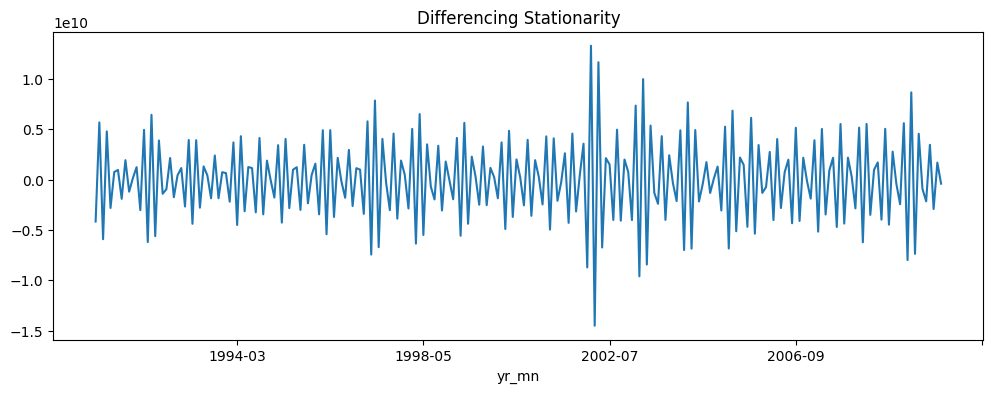

In [10]:
from statsmodels.tsa.statespace.tools import diff

group1["difference_12"] = diff(group1["Passengers"], k_diff=12)
group1["difference_12"].plot(figsize=(12,4))
plt.title('Differencing Stationarity')
plt.show()

In [11]:
# Ad Fuller test for seasonal difference in the data

adft2 = adfuller(group1['difference_12'].dropna(),autolag="AIC")
output_df1 = pd.DataFrame({"Values": [adft2[0], adft2[1], adft2[2], adft2[3], adft2[4]['1%'],
                                      adft2[4]['5%'], adft2[4]['10%']],
                           "Metric":["Test Statistics", "p-value", "No. of lags used", "Number of observations used", 
                                     "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
(output_df1)

,Values,Metric
0,-1.660637e+01,Test Statistics
1,1.746406e-29,p-value
2,1.500000e+01,No. of lags used
3,2.120000e+02,Number of observations used
4,-3.461578e+00,critical value (1%)
5,-2.875272e+00,critical value (5%)
6,-2.574089e+00,critical value (10%)


Now from the above we reject the null hypothesis. And find that the data is stationary on a 12 month basis

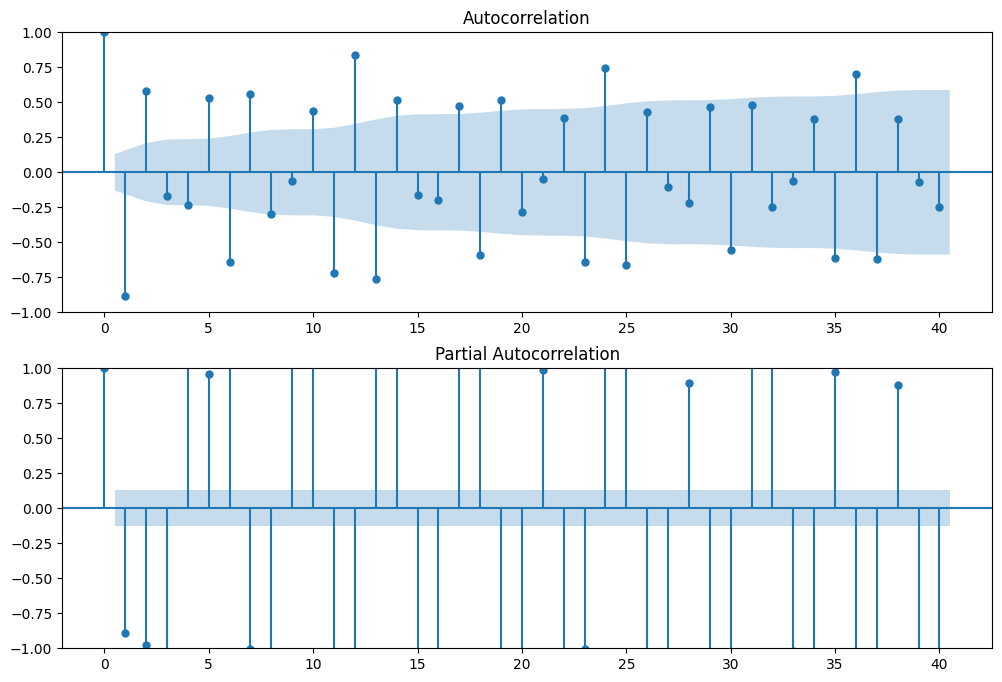

In [12]:
# Auto Correlation Analysis Between Past and Present Data to generate the p,q,d values
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(group1['difference_12'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(group1['difference_12'].iloc[13:], lags=40, ax=ax2)
plt.show()

In [13]:
# Train Test Split for Time Series Prediction

group1.index = pd.to_datetime(group1.index)

train = group1.iloc[:len(group1)-48]
test = group1.iloc[len(group1)-48:]

model = sm.tsa.statespace.SARIMAX(group1['Passengers'], order=(7, 2, 1), seasonal_order=(1,1,1,12))
results = model.fit()
results.summary()

/Users/superadmin/opt/anaconda3/envs/airport/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/superadmin/opt/anaconda3/envs/airport/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50801D+01    |proj g|=  4.23295D-01

At iterate    5    f=  1.49160D+01    |proj g|=  4.48626D-02

At iterate   10    f=  1.48962D+01    |proj g|=  9.71937D-03

At iterate   15    f=  1.48917D+01    |proj g|=  1.43831D-02

At iterate   20    f=  1.48874D+01    |proj g|=  3.35762D-03

At iterate   25    f=  1.48873D+01    |proj g|=  1.13686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     26     28      1     0     0   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  240
Model:             SARIMAX(7, 2, 1)x(1, 1, 1, 12)   Log Likelihood               -3572.957
Date:                            Sat, 04 Feb 2023   AIC                           7167.913
Time:                                    14:05:46   BIC                           7205.539
Sample:                                01-01-1990   HQIC                          7183.097
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3113      0.108     -2.888      0.004      -0.523      -0.100
ar.L2         -0.0858      0.063     -1.369      0.171      -0.209       0.037
ar.L3         -0.0798      0.083     -0.964      0.335      -0.242       0.082
ar.L4         -0.0421      0.104     -0.403      0.687      -0.247       0.163
ar.L5         -0.0686      0.125     -0.547      0.584      -0.314       0.177
ar.L6         -0.0681      0.116     -0.587      0.557      -0.296       0.159
ar.L7          0.0218      0.114      0.191      0.848      -0.201       0.245
ma.L1         -0.9897      0.047    -21.158      0.000      -1.081      -0.898
ar.S.L12       0.3697      0.094      3.951      0.000       0.186       0.553
ma.S.L12      -0.7330      0.092     -7.970      0.000      -0.913      -0.553
sigma2      4.138e+12   2.15e-14   1.93e+26      0.000    4.14e+12    4.14e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):              8656.06
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -2.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.92e+40. Standard errors may be unstable.
"""

### Model Validation

Test R2: 0.890


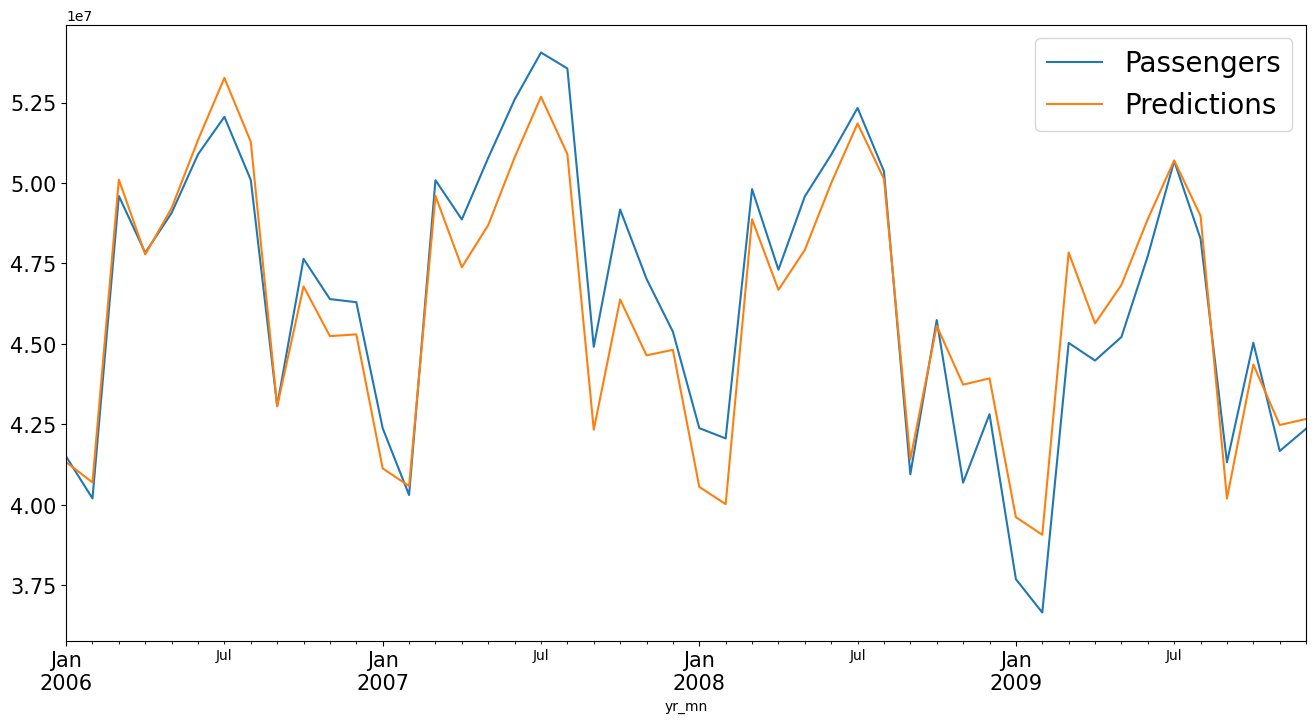

In [14]:
# Validating the model
from sklearn.metrics import mean_squared_error, r2_score
start = len(train)
end = len(train)+ len(test)-1
prediction=results.predict(start,end,dynamic=True).rename('Predictions')

r2 = r2_score(test.Passengers, prediction)
print('Test R2: %.3f' % r2)

ax = test['Passengers'].plot(legend = True, figsize = (16,8))
prediction.plot(legend=True)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Making Predictions for Next 4 Years

In [15]:
# Making predictions 48 months into the future
# Adding new dates to the model

from pandas.tseries.offsets import DateOffset
future_dates = [group1.index[-1] + DateOffset(months=x)for x in range(0,48)]
future_datest_df = pd.DataFrame(index=future_dates[1:], columns=group1.columns)

In [16]:
future_df = pd.concat([group1, future_datest_df])
future_df.shape

(287, 2)

Predicted average passengers for the next 4 years = 40781612.981333956


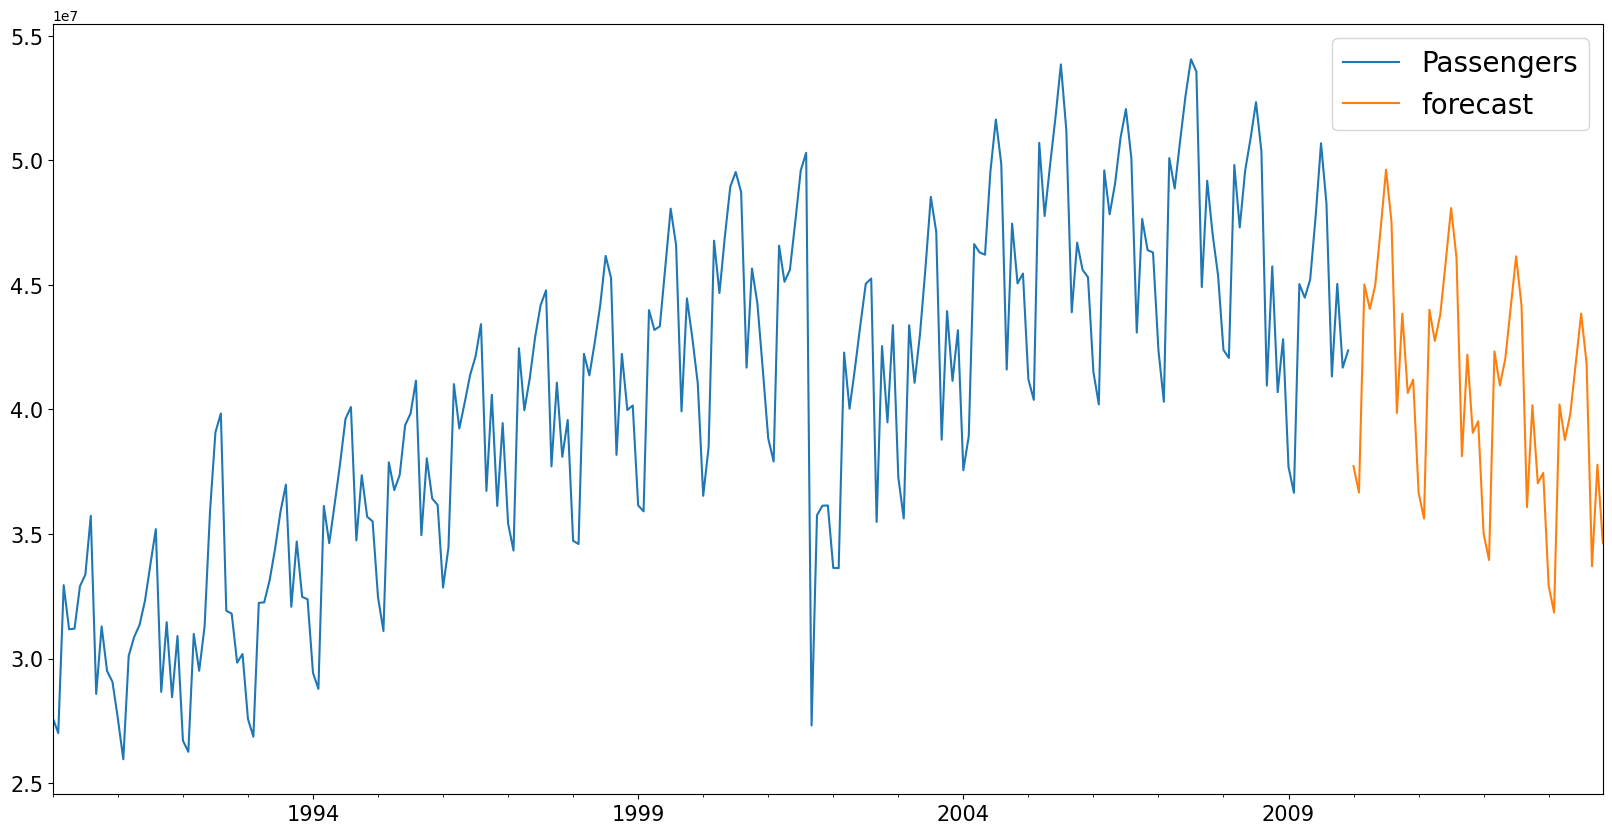

In [17]:
future_df['forecast'] = results.predict(start = 240, end = 287, dynamic= True)  
future_df[['Passengers', 'forecast']].plot(figsize=(20, 10)) 
new_mean= future_df.forecast.dropna()

print('Predicted average passengers for the next 4 years =', np.mean(new_mean))
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Random Forest Regression Analysis To Generate Important Variables for Flights 

## Data Preprocessing

In [18]:
# Adding categorical variables looking at Origin Population

new_catg = []

for i in range(df.Origin_population.shape[0]):
    x = df.Origin_population.iloc[i]
    if x <1000000:
        new_catg.append('Low')
    elif x > 1000000 and x <= 5000000:
        new_catg.append('Medium')
    elif x > 5000000:
        new_catg.append('Large')

df.loc[:,"Origin_poplulation_Cat"] = new_catg

In [19]:
# Adding categorical variables looking at Destination Population

new_catg2 = []

for i in range(df.Destination_population.shape[0]):
    y = df.Destination_population.iloc[i]
    if y < 1000000:
        new_catg2.append('Low')
    elif y > 1000000 and y <= 5000000:
        new_catg2.append('Medium')
    elif y > 5000000:
        new_catg2.append('Large')

df.loc[:,"Destination_population_Cat"] = new_catg2

In [20]:
df['Day_of_Week'] = df['new_date'].apply(lambda time: time.dayofweek)

In [21]:
# Adding Days columns from the date
new_catg3 = []

for i in range(df.Day_of_Week.shape[0]):
    y = df.Day_of_Week.iloc[i]
    if y == 0:
        new_catg3.append('Mon')
    elif y == 1:
        new_catg3.append('Tues')
    elif y == 2:
        new_catg3.append('Wed')
    elif y == 3:
        new_catg3.append('Thur')
    elif y == 4:
        new_catg3.append('Fri')
    elif y == 5:
        new_catg3.append('Sat')
    else:
        new_catg3.append('Sun')

df.loc[:,"Day"] = new_catg3

df = df.drop(columns=['Day_of_Week'])
df['Flights'] = pd.to_numeric(df['Flights'])

In [22]:
# Grouping data to see flights arrival pattern across the days of the week
day_data = df.groupby(['Destination_city','Day']).agg(
    {'Passengers': 'sum','Distance':'mean','Destination_population':'mean',
     'Origin_population':'mean','Flights':'sum'}).reset_index()

In [23]:
# Creating Dummy Variables from the Day and Population Category column to be used as variables in the Regression Model
dummies = pd.get_dummies(day_data.Day)

day_data = pd.concat([day_data, dummies], axis=1)

day_data

,Destination_city,Day,Passengers,Distance,Destination_population,Origin_population,Flights,Fri,Mon,Sat,Sun,Thur,Tues,Wed
0,"Aberdeen, SD",Fri,63708,152.730435,39238.304348,8.618349e+05,4423,1,0,0,0,0,0,0
1,"Aberdeen, SD",Mon,67241,157.776119,39303.485075,8.762866e+05,4696,0,1,0,0,0,0,0
2,"Aberdeen, SD",Sat,60977,172.977941,39266.367647,9.586573e+05,4466,0,0,1,0,0,0,0
3,"Aberdeen, SD",Sun,64972,154.774194,39224.540323,8.708563e+05,4639,0,0,0,1,0,0,0
4,"Aberdeen, SD",Thur,63706,167.629630,39224.814815,9.836563e+05,4711,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,"Yuma, AZ",Sat,102393,344.686441,172194.542373,6.298299e+06,6652,0,0,1,0,0,0,0
2705,"Yuma, AZ",Sun,99742,328.177419,171377.209677,5.728072e+06,6385,0,0,0,1,0,0,0
2706,"Yuma, AZ",Thur,97685,310.533333,172491.750000,6.247828e+06,6366,0,0,0,0,1,0,0
2707,"Yuma, AZ",Tues,99902,244.154545,174667.472727,6.052727e+06,6603,0,0,0,0,0,1,0


### Running the Model 

In [24]:
import copy

day_data2 = copy.deepcopy(day_data)

day_data2.head()
labels = (day_data2['Flights'])
day_data2= day_data2.drop('Flights', axis = 1)
feature_list = list(day_data2.columns) 

features = (day_data2[['Origin_population','Destination_population','Distance','Mon','Tues','Wed',
                       'Thur','Fri','Sat','Sun']])

train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.33, random_state = 42)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

rfc = RandomForestRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10,20,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 4)
CV_rfc.fit(train_features, train_labels)

GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 100, 200]})

In [26]:
CV_rfc.best_params_

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}

In [27]:
# Import the Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_features='auto', max_depth=10, n_jobs=-1)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=200,
                      n_jobs=-1)

### Model Assesment

In [28]:
# Use the forest's predict method on the test data

predictions = rf.predict(test_features)
# Calculate the r2 value

r2 = r2_score(test_labels, predictions)
#Print out the R^2 of the prediction
print('R^2:', round(r2, 2))

R^2: 0.93


### Feature Importance

In [29]:
# Finding the important features to predict number of flights originating

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

feat_labels = features.columns

for f in range(features.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) Destination_population         0.723918
 2) Origin_population              0.204445
 3) Distance                       0.067222
 4) Sat                            0.001117
 5) Tues                           0.001101
 6) Thur                           0.000757
 7) Sun                            0.000620
 8) Fri                            0.000412
 9) Wed                            0.000243
10) Mon                            0.000166


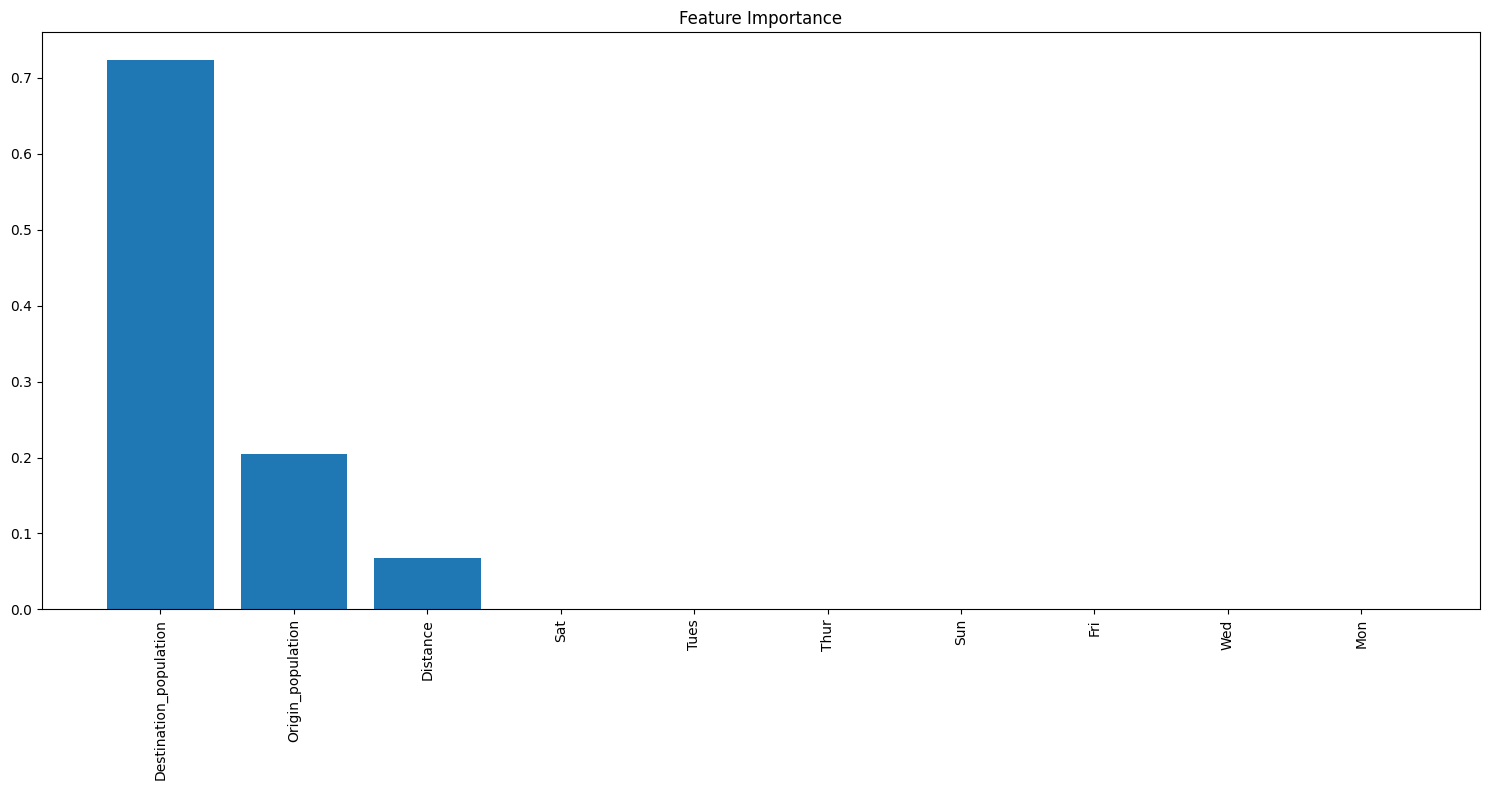

In [30]:
# Plotting the feature importance

plt.figure(figsize = (15,8))

plt.title('Feature Importance')

plt.bar(range(features.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(features.shape[1]), train_features.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()